# **Practica 2**
#### _Alberto García Doménech - Pablo Daurell Marina_ (Grupo 10)
***

## Parte 1 (Análisis de sentimiento)

In [140]:
import pandas as pd

In [187]:
df = pd.read_csv("yelp_labelled.txt", sep='\t', names=['Data', 'Target'])
data = df.to_numpy()[:, 0]
target = df.to_numpy()[:, 1]
target = target.astype('int')

In [188]:
for i in range(10):
    print(data[i], target[i])

Wow... Loved this place. 1
Crust is not good. 0
Not tasty and the texture was just nasty. 0
Stopped by during the late May bank holiday off Rick Steve recommendation and loved it. 1
The selection on the menu was great and so were the prices. 1
Now I am getting angry and I want my damn pho. 0
Honeslty it didn't taste THAT fresh.) 0
The potatoes were like rubber and you could tell they had been made up ahead of time being kept under a warmer. 0
The fries were great too. 1
A great touch. 1


In [189]:
from sklearn.model_selection import train_test_split

a, b, c, d = train_test_split(df['Data'], df['Target'], test_size=0.25, random_state=0)
train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.25, random_state=0)

In [190]:
print("Training size: ", train_data.size)
print("Test size: ", test_data.size)

Training size:  750
Test size:  250


In [191]:
import numpy as np
import numpy.ma as ma

def write_terms (feature_names, data, vector_data, index):
    '''
    Escribe los términos presentes en un mensaje representado como bolsa de palabras.
    
    - feature_names: terminos usados para vectorizar
    - data: lista de mensajes original (si data==None no se muestra el mensaje original)
    - vector_data: matriz (dispersa) de mensaje vectorizados
    - index: posición del mensaje a mostrar
    '''
    # máscara para seleccionar sólo el mensaje en posición index
    mask=vector_data[index,:]>0
    
    # términos que aparecen en ese mensaje vectorizado
    terminos = ma.array(feature_names, mask = ~(mask[0].toarray()))
    
    # mostrar mensaje original
    if data.any():
        print('Mensaje', index, ':', data[index])
    
    # mostrar términos que aparecen en el mensaje vectorizado
    print('Mensaje', index, 'vectorizado:', terminos.compressed(),'\n')

## A) Bolsas de palabras

In [192]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

### 1. Bolsa de palabras binaria y n-gramas (1,1) 

Creamos una bolsa de palabras con monogramas (solo tenemos en cuenta la probabilidad de una palabra, independientemente del resto) y que tenga en cuenta si una palabra aparece o no:

In [193]:
vectorizer = CountVectorizer(stop_words='english', binary=True, ngram_range = (1,1)) 
train_vector_data = vectorizer.fit_transform(train_data)

feature_names = vectorizer.get_feature_names()
print(len(feature_names))

1510


Ajustamos los datos de test al modelo de bolsa de palabra que acabamos de crear:

In [194]:
test_vector_data = vectorizer.transform(test_data)
print(test_vector_data.shape)

(250, 1510)


Con ayuda de la función ```write_terms```, previamente definida, podemos ver algunos ejemplos de como se han vectorizado los mensajes:

In [195]:
write_terms(feature_names, train_data, train_vector_data, 1)
write_terms(feature_names, train_data, train_vector_data, 10)
write_terms(feature_names, train_data, train_vector_data, 100)

Mensaje 1 : And the chef was generous with his time (even came around twice so we can take pictures with him).
Mensaje 1 vectorizado: ['came' 'chef' 'generous' 'pictures' 'time' 'twice'] 

Mensaje 10 : The cashew cream sauce was bland and the vegetables were undercooked.
Mensaje 10 vectorizado: ['bland' 'cashew' 'cream' 'sauce' 'undercooked' 'vegetables'] 

Mensaje 100 : Now this dish was quite flavourful.
Mensaje 100 vectorizado: ['dish' 'flavourful' 'quite'] 



#### 1.1 Naive Bayes:

In [251]:
from sklearn.naive_bayes import MultinomialNB

mnb_classifier = MultinomialNB()

mnb_classifier.fit(train_vector_data, train_target)

mnb_train_predictions = mnb_classifier.predict(train_vector_data)
mnb_test_predictions = mnb_classifier.predict(test_vector_data)

print("Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento:", np.mean(mnb_train_predictions == train_target))
print("Multinomial Naive Bayes, porcentaje de aciertos en test:", np.mean(mnb_test_predictions == test_target))

Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento: 0.9573333333333334
Multinomial Naive Bayes, porcentaje de aciertos en test: 0.728


#### 1.2 Árbol de decisión:

**PROBAR VALORES PARA max_depth Y ELEGIR EL MEJOR**   
**(probar en vez de max_depth: min_samples_leaf o max_leaf_nodes)**

In [276]:
from sklearn import tree

train_accuracy = []
test_accuracy = []

max_depths = range(1, 50)
for md in max_depths: 
    # Entrenar y validar
    tree_classifier = tree.DecisionTreeClassifier(criterion="entropy", max_depth=md, min_samples_split=2)
    tree_classifier.fit(train_vector_data, train_target)
                        
    tree_train_predictions = tree_classifier.predict(train_vector_data)
    tree_test_predictions = tree_classifier.predict(test_vector_data)    
    
    train_accuracy.append(np.mean(tree_train_predictions == train_target))
    test_accuracy.append(np.mean(tree_test_predictions == test_target))

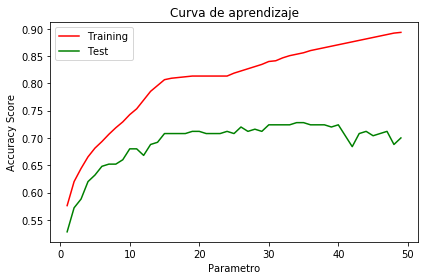

In [277]:
import matplotlib.pyplot as plt

# Draw lines
plt.plot(max_depths, train_accuracy, color="r",  label="Training")
plt.plot(max_depths, test_accuracy, color="g", label="Test")

# Create plot
plt.title("Curva de aprendizaje")
plt.xlabel("Parametro"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()   

In [271]:
from sklearn import tree

tree_classifier = tree.DecisionTreeClassifier(random_state=0)
tree_classifier.fit(train_vector_data, train_target)

tree_train_predictions = tree_classifier.predict(train_vector_data)
tree_test_predictions = tree_classifier.predict(test_vector_data)

print("Árbol, porcentaje de aciertos en entrenamiento:", np.mean(tree_train_predictions == train_target))
print("Árbol, porcentaje de aciertos en test:", np.mean(tree_test_predictions == test_target))

Árbol, porcentaje de aciertos en entrenamiento: 0.996
Árbol, porcentaje de aciertos en test: 0.676


### 2. Bolsa de palabras con TF-IDF y n-gramas (1,1)

Creamos una bolsa de palabras con monogramas (solo tenemos en cuenta la probabilidad de una palabra, independientemente del resto) y que tenga en cuenta la frecuencia de aparición:

In [21]:
vectorizer = CountVectorizer(stop_words='english', binary=False, ngram_range = (1,1))
train_vector_data = vectorizer.fit_transform(train_data)

feature_names = vectorizer.get_feature_names()
print(len(feature_names))

1510


Una vez generada la bolsa de palabras, convertimos los valores de frecuencia a TF-IDF:

In [22]:
tfider = TfidfTransformer()
train_preprocessed = tfider.fit_transform(train_vector_data)
print(train_preprocessed.shape)

(750, 1510)


Ajustamos los datos de test al modelo de bolsa de palabra que acabamos de crear:

In [23]:
test_vector_data = vectorizer.transform(test_data)
test_preprocessed = tfider.transform(test_vector_data)
print(test_preprocessed.shape)

(250, 1510)


#### 2.1 Naive Bayes:

#### 2.2 Árbol de decisión:

### 3. Bolsa de palabras binarias y n-gramas (1,2)

In [81]:
binary_bigram_vectorizer = CountVectorizer(stop_words='english', binary=True, ngram_range = (1,2))
train_vector_data = vectorizer.fit_transform(X_train)
feature_names = vectorizer.get_feature_names()
print(len(feature_names))

4347


### 4. Bolsa de palabras con TF-IDF y n-gramas (1,2)

In [85]:
tfidf_bigram_vectorizer = CountVectorizer(stop_words='english', binary=False ,ngram_range = (1,2))
train_vector_data = vectorizer.fit_transform(X_train)
feature_names = vectorizer.get_feature_names()
print(len(feature_names))

4347


In [ ]:
import numpy as np
import numpy.ma as ma

def write_terms (feature_names, data, vector_data, index):
    '''
    Escribe los términos presentes en un mensaje representado como bolsa de palabras.
    
    - feature_names: terminos usados para vectorizar
    - data: lista de mensajes original (si data==None no se muestra el mensaje original)
    - vector_data: matriz (dispersa) de mensaje vectorizados
    - index: posición del mensaje a mostrar
    '''
    # máscara para seleccionar sólo el mensaje en posición index
    mask=vector_data[index,:]>0
    
    # términos que aparecen en ese mensaje vectorizado
    terminos = ma.array(feature_names, mask = ~(mask[0].toarray()))
    
    # mostrar mensaje original
    if data.any():
        print('Mensaje', index, ':', data[index])
    
    # mostrar términos que aparecen en el mensaje vectorizado
    print('Mensaje', index, 'vectorizado:', terminos.compressed(),'\n')

In [ ]:
write_terms(feature_names, X_train, train_vector_data, 1)